# https://scib-metrics.readthedocs.io/en/latest/notebooks/lung_example.html

In [1]:

import warnings
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib as mpl
import scanpy as sc

import numpy as np
import pandas as pd
import scanpy as sc
from sklearn.metrics import normalized_mutual_info_score

from scbiot.ot.coembedding import (    
    build_aligned_coembedding,
    harmonize_gene_names,
    label_transfer_shared_pca,
    preprocess_atac,
)

from scbiot.utils import set_seed

warnings.filterwarnings("ignore")
set_seed(42)

dir = Path.cwd()
print(dir)
print(dir.parent)


/home/figo/software/python_libs/scbiot/.venv/lib/python3.12/site-packages/scanpy/_utils/__init__.py:33: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('anndata')` instead.
  from anndata import __version__ as anndata_version
/home/figo/software/python_libs/scbiot/.venv/lib/python3.12/site-packages/scanpy/__init__.py:24: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('anndata')` instead.
  if Version(anndata.__version__) >= Version("0.11.0rc2"):
/home/figo/software/python_libs/scbiot/.venv/lib/python3.12/site-packages/scanpy/readwrite.py:16: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('anndata')` instead.
  if Version(anndata.__version__) >= Version("0.11.0rc2"):


Random seed set as 42
/home/figo/software/python_libs/scbiot/examples
/home/figo/software/python_libs/scbiot


In [2]:
adata_gex = sc.read_h5ad(f'{dir}/inputs/Yao-2021-RNA.h5ad')
adata_atac = sc.read_h5ad(f'{dir}/inputs/Yao-2021-ATAC.h5ad')

In [ ]:

# 0) ATAC preprocessing (peak filtering -> TF-IDF/LSI -> GA + smoothing)
atac_prep = preprocess_atac(
    adata_atac,
    gtf_file=f"{dir}/inputs/gencode.vM25.chr_patch_hapl_scaff.annotation.gtf.gz",    
    verbose=True,
)
adata_ga = atac_prep.ga

# Harmonize gene names & build aligned co-embedding
harmonize_gene_names(adata_gex, adata_ga, rna_name_col="gene_name", verbose=True)


Removed 19,172 promoter-proximal peaks (2000bp upstream / 500bp downstream). Remaining: 129,642
Running Iterative LSI iteration 1 ...
Running Iterative LSI iteration 2 ...
Running Iterative LSI iteration 3 ...
Running Iterative LSI iteration 4 ...
Running Iterative LSI iteration 5 ...
[GA] Kept 22,358/56,262 genes by biotype ['protein_coding', 'lncRNA']
[GA] Peaks contigs: 21; Genes contigs: 108; Common: 21
[GA] Using gene field: gene_name
[GA] Built GA with shape (54844, 12175) (cells × genes) from 148,814 peaks.


In [ ]:
adata_ga.var_names[:10]

Index(['-1', '0610010F05Rik', '0610010K14Rik', '0610012G03Rik',
       '0610030E20Rik', '0610040J01Rik', '1110002E22Rik', '1110008P14Rik',
       '1110012L19Rik', '1110017D15Rik'],
      dtype='object')

In [ ]:

coembed = build_aligned_coembedding(adata_gex, adata_ga, verbose=True)
genes_joint = coembed.genes
rep_key = coembed.embedding_key
print(f"[HVG] Joint (shared) HVGs: {len(genes_joint):,}")


# 5) Optional OT transport-based label projection onto GA + ATAC
if "cell_type" in adata_atac.obs and "cell_type_original" not in adata_atac.obs:
    adata_atac.obs["cell_type_original"] = adata_atac.obs["cell_type"].astype(str)


label_transfer_shared_pca(
    adata_gex,
    adata_ga,
    label_key="cell_type",
    use_rep="X_pca_shared_aligned",
    min_conf=0.55,
)

true_labels = adata_ga.obs.get("cell_type_original", adata_ga.obs.get("cell_type"))
pred_labels = adata_ga.obs["pred_cell_type"]
pred_labels_str = pred_labels.astype(str)
mask = (~pd.isna(true_labels)) & (~pd.isna(pred_labels)) & (pred_labels_str != "unknown")
if mask.any():
    nmi_score = normalized_mutual_info_score(
        true_labels[mask].astype(str),
        pred_labels_str[mask],
    )
    print(f"[Metrics] NMI(pred_cell_type vs cell_type) = {nmi_score:.4f}")
    

joint_rep_key = rep_key
adata = atac_prep.assemble_joint_embedding(joint_rep_key, {"RNA": adata_gex})


[OT] 'X_pca_shared_aligned' updated with GA→RNA barycentric OT (top-64 transport stored).
[HVG] Joint (shared) HVGs: 4,994
[Metrics] NMI(pred_cell_type vs cell_type) = 0.7096


In [ ]:
sc.pp.neighbors(adata, use_rep='X_pca_shared_aligned', n_neighbors=50, metric="cosine")
sc.tl.umap(adata, min_dist=0.3, spread=1.0, random_state=0)

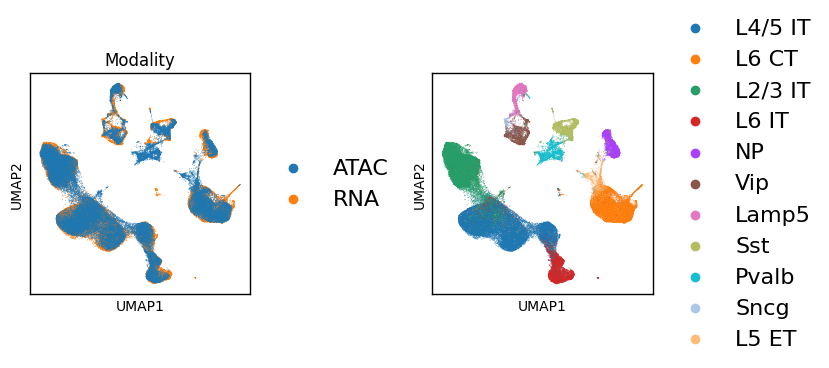

In [ ]:
counts = adata_gex.obs['cell_type'].value_counts()
celltype_order = counts.index.tolist()
adata.obs['cell_type'] = adata.obs['cell_type'].astype(
    pd.CategoricalDtype(categories=celltype_order, ordered=True)  # from adata_gex
)


sc.settings._vector_friendly = True

# Make sure the default edge isn’t white or hairline
mpl.rcParams['axes.edgecolor'] = 'black'
mpl.rcParams['axes.linewidth'] = 1.0

def force_border(ax):
    ax.set_axis_on()           # ensure axes are on
    ax.set_frame_on(True)      # ensure frame is drawn
    ax.patch.set_visible(True) # ensure background patch exists
    for side in ax.spines.values():
        side.set_visible(True)
        side.set_color('black')
        side.set_linewidth(1.0)

methods = ["X_pca_shared_aligned"]

ncols = 2 * len(methods)
fig, axes = plt.subplots(1, ncols, figsize=(4.2*ncols, 4.2), squeeze=False)
axes = axes[0]

for i, method in enumerate(methods):
    basis = f"X_umap_{method}"
    axL, axR = axes[2*i], axes[2*i+1]   

    sc.pl.embedding(
        adata, basis="umap", color="modality",
        frameon=True, ax=axL, show=False,
        legend_loc="right margin", legend_fontsize=16, title='Modality'
    )
    axL.set_box_aspect(1)
    axL.set_xlabel("UMAP1"); axL.set_ylabel("UMAP2")
    force_border(axL)    

    sc.pl.embedding(
        adata, basis="umap", color="cell_type", # "scBIOT_celltype", #"cell_type",
        frameon=True, ax=axR, show=False,
        legend_loc="right margin", legend_fontsize=16, title=""
    )
    axR.set_box_aspect(1)
    axR.set_xlabel("UMAP1"); axR.set_ylabel("UMAP2")
    force_border(axR)

plt.tight_layout()
# fig.savefig(f"{cwd}_batch_and_leiden_per_embedding.pdf", dpi=300, transparent=True)


cell types: ['L4/5 IT', 'L6 CT', 'L2/3 IT', 'L6 IT', 'NP', 'Vip', 'Lamp5', 'Sst', 'Pvalb', 'Sncg', 'L5 ET']


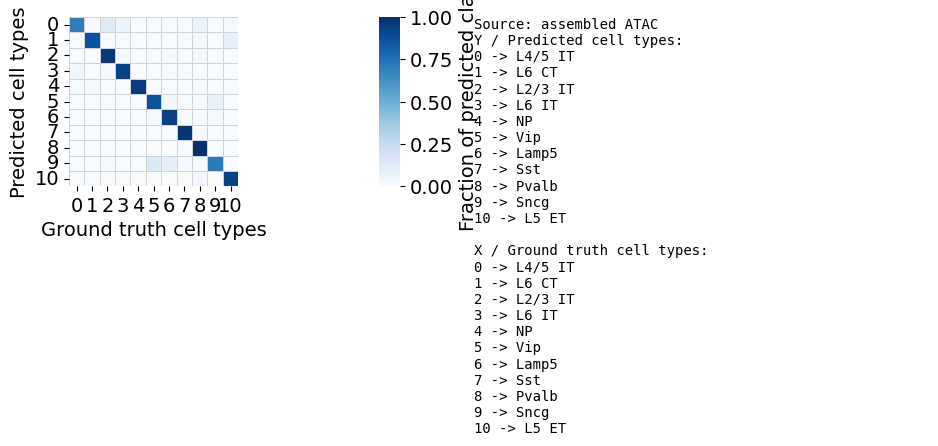

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec

counts = adata_gex.obs['cell_type'].value_counts()
celltype_order = counts.index.tolist()
print(f'cell types: {celltype_order}')

pred_col_candidates = ["pred_cell_type", "predicted_cell_type"]
truth_col_candidates = ["cell_type_original", "cell_type", "final_cell_label"]
obs_candidates = []

if "adata" in locals():
    obs_view = adata.obs.copy()
    if "modality" in obs_view.columns:
        obs_view = obs_view[obs_view["modality"] == "ATAC"]
    obs_candidates.append(("assembled ATAC", obs_view))
if "adata_ga" in locals():
    obs_candidates.append(("gene activity", adata_ga.obs.copy()))
if "adata_atac" in locals():
    obs_candidates.append(("raw ATAC", adata_atac.obs.copy()))

selected_obs = None
selected_source = None
for label, frame in obs_candidates:
    if frame is None or frame.empty:
        continue
    pred_col = next((col for col in pred_col_candidates if col in frame.columns), None)
    truth_col = next((col for col in truth_col_candidates if col in frame.columns), None)
    if pred_col and truth_col:
        selected_obs = frame[[pred_col, truth_col]].copy()
        selected_obs.columns = ["predicted", "truth"]
        selected_source = label
        break

if selected_obs is None:
    print("No matching predicted and ground truth annotations found; skipping confusion matrix.")
else:
    selected_obs = selected_obs.dropna().copy()
    if not selected_obs.empty:
        selected_obs["predicted"] = selected_obs["predicted"].astype(str)
        selected_obs["truth"] = selected_obs["truth"].astype(str)
        mask = (selected_obs["predicted"].str.lower() != "unknown") & (selected_obs["truth"].str.lower() != "unknown")
        selected_obs = selected_obs.loc[mask]
    if selected_obs.empty:
        print("No overlapping predicted and ground truth labels after filtering; skipping confusion matrix.")
    else:
        contingency = pd.crosstab(selected_obs["predicted"], selected_obs["truth"])

        truth_order = [ct for ct in celltype_order if ct in contingency.columns]
        truth_order += [ct for ct in contingency.columns if ct not in truth_order]
        pred_order = [ct for ct in celltype_order if ct in contingency.index]
        pred_order += [ct for ct in contingency.index if ct not in pred_order]

        contingency = contingency.reindex(index=pred_order, columns=truth_order, fill_value=0)
        row_sums = contingency.sum(axis=1).replace(0, np.nan)
        contingency_norm = contingency.div(row_sums, axis=0).fillna(0)

        fig = plt.figure(figsize=(10, 3.6), constrained_layout=True)
        gs = GridSpec(nrows=1, ncols=3, figure=fig, width_ratios=[1.0, 0.05, 1.05])
        ax = fig.add_subplot(gs[0])
        cax = fig.add_subplot(gs[1])
        lax = fig.add_subplot(gs[2])

        hm = sns.heatmap(
            contingency_norm,
            ax=ax,
            cmap="Blues",
            vmin=0, vmax=1,
            linewidths=0.5, linecolor="lightgrey",
            cbar=True, cbar_ax=cax,
            cbar_kws={"label": "Fraction of predicted class"},
        )
        cbar = hm.collections[0].colorbar
        cbar.ax.tick_params(labelsize=14)
        cbar.set_label("Fraction of predicted class", fontsize=14)

        ax.set_yticklabels(list(range(len(contingency_norm.index))), rotation=0, fontsize=14)
        ax.set_xticklabels(list(range(len(contingency_norm.columns))), rotation=0, ha="center", fontsize=14)
        ax.set_ylabel("Predicted cell types", fontsize=14)
        ax.set_xlabel("Ground truth cell types", fontsize=14)
        ax.set_aspect("equal")

        lax.axis("off")
        map_y = [f"{i} -> {name}" for i, name in enumerate(contingency_norm.index)]
        map_x = [f"{i} -> {name}" for i, name in enumerate(contingency_norm.columns)]
        legend_text = (
            f"Source: {selected_source}\n"
            + "Y / Predicted cell types:\n" + "\n".join(map_y) + "\n\n"
            + "X / Ground truth cell types:\n" + "\n".join(map_x)
        )
        lax.text(0.0, 1.0, legend_text, va="top", ha="left", fontsize=10, family="monospace")

        # output_path = cwd / f"{DATASET}_atac_pred_vs_truth_confusion.pdf"
        # fig.savefig(output_path, dpi=300)
        plt.show()
        plt.close(fig)
        # print(f"[Confusion] Saved plot ({len(selected_obs)} cells) from {selected_source} to {output_path}")


In [ ]:

# output_dir.mkdir(parents=True, exist_ok=True)
# adata.write_h5ad(output_dir / "alldata.h5ad")
